In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

from torchinfo import summary
from torchmetrics.functional.classification import multiclass_accuracy

import numpy as np
import matplotlib.pyplot as plt

import cv2

In [145]:
### Resizing
preprocessing = transforms.Compose(transforms=[
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [146]:
## ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1  Device: cpu


## 이미지 데이터셋

In [147]:
from torchvision.datasets import ImageFolder

In [148]:
train_root = '../data/img/train'
test_root = '../data/img/test'

trainDS = ImageFolder(root=train_root, transform=preprocessing)
testDS = ImageFolder(root=test_root, transform=preprocessing)

In [149]:
trainDS.classes, trainDS.class_to_idx

(['chihuahua', 'muffin'], {'chihuahua': 0, 'muffin': 1})

In [150]:
from torch.utils.data import DataLoader
trainDL = DataLoader(trainDS)
testDL = DataLoader(testDS)

for (img,label) in trainDL:
    print(img.shape, label.shape, label)
    break

torch.Size([1, 3, 50, 50]) torch.Size([1]) tensor([0])


# 데이터 준비

In [151]:
BATCH_SIZE =10
EPOCHS = 10

In [152]:
# dataload 다시
train_loader = torch.utils.data.DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=True)

In [153]:
### ==> 데이터 확인하기 (1)
### ==> x_train : torch.size([32,3,50,50])[배치사이즈, 채널, 높이, 너비]
### ==> y_train : torch.size([72])[배치사이즈] 즉 72개 이미지에 대한 라벨
for (X_train,y_train) in train_loader:
    print('X_train:',X_train.size(), 'type:',X_train.type())
    print('y_train:',y_train.size(), 'type:',y_train.type())
    break
    

X_train: torch.Size([10, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([10]) type: torch.LongTensor


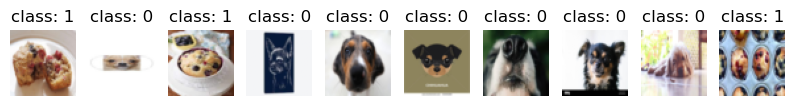

In [154]:
### ==> 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
    plt.subplot(1,10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
    plt.title('class: ' + str(y_train[i].item()))

In [155]:
max = 10
for cnt, (_, label) in enumerate(train_loader):
    print(f'batch별 target 분포\n{label.bincount()}\n')
    if cnt > max:
        break

batch별 target 분포
tensor([6, 4])

batch별 target 분포
tensor([6, 4])

batch별 target 분포
tensor([4, 6])

batch별 target 분포
tensor([5, 5])
batch별 target 분포
tensor([6, 4])

batch별 target 분포
tensor([4, 6])

batch별 target 분포
tensor([8, 2])
batch별 target 분포
tensor([6, 4])

batch별 target 분포
tensor([5, 5])

batch별 target 분포
tensor([6, 4])
batch별 target 분포
tensor([7, 3])

batch별 target 분포
tensor([4, 6])


- 모델 설계

In [156]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels =8, kernel_size = 3, padding =1)
        self.conv2 = nn.Conv2d(in_channels =8, out_channels = 16, kernel_size = 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(12*12*16,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.Sig(x)
        return x
        

- 학습 준비

In [157]:

### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

cost = torch.nn.BCELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (Sig): Sigmoid()
)


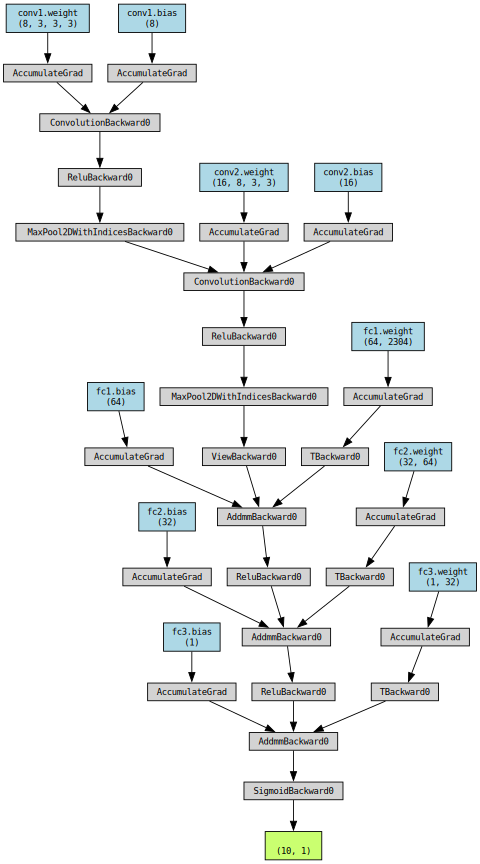

In [158]:
from torchviz import make_dot

#x=torch.randn(1,3,32,32).to(DEVICE)
#y=model(x)

make_dot(model(X_train),params=dict(model.named_parameters()))

In [159]:
def train(epoch, model, train_loader, optimizer,log_interval,scheduler):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        # output_probs = torch.sigmoid(output)
        label=label.unsqueeze(dim=-1)
        #print(image.shape, label.shape, output.shape)
        loss = F.binary_cross_entropy(output,label.float())
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}')

In [160]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(images)
            
            # 이진 분류에서는 레이블을 0 또는 1로 표현
            labels = labels.unsqueeze(1)  # 레이블을 [batch_size, 1]로 확장
            labels = labels.float()  # float 형태로 변환
            
            # 손실 계산
            test_loss += F.binary_cross_entropy(outputs, labels).item()
            
            # 정확도 계산
            correct += (outputs == labels.view(-1)).sum().item()
            total += labels.size(0)
            
    test_loss /= len(test_loader)
    test_accuracy =  correct / len(test_loader)/10
    
    return test_loss, test_accuracy


In [162]:
### ===> CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_loader, optimizer, log_interval = 200,scheduler=scheduler)
    test_loss,test_accuracy = evaluate(model,test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1 [0]	Train Loss: 50.000000

[EPOCH: 1], 	Test Loss: 50.0990, 	Test Accuracy: 4.94 % 

Train Epoch: 2 [0]	Train Loss: 60.000000

[EPOCH: 2], 	Test Loss: 50.0990, 	Test Accuracy: 4.94 % 

Train Epoch: 3 [0]	Train Loss: 60.000000


KeyboardInterrupt: 

In [ ]:
# 모델 저장
torch.save(model.state_dict(), 'model.pth')

# 모델 로드
model = CNN()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # 추론 모드로 설정

# 이미지 예측
img=cv2.imread('../data/img/train/chihuahua/img_0_0.jpg')
img=cv2.resize(img,(50,50))
img=np.transpose(img,(2,0,1))
img = torch.Tensor(img)
img = img.unsqueeze(0)

with torch.no_grad():
    output = model(img)
    _,predicted = torch.max(output.data,1)
predicted